In [1]:
import numpy as np
from sklearn.cross_validation import train_test_split
from PIL import Image
import cv2 as cv
import os

class NotFaminist:
    def __init__(self):
        images, labels = [], []

        for i, letter in enumerate(['0', '1']):
            directory = '/Users/yamamotomasaomi/Documents/Github/Python_Study/opencv/notFaminist/%s/' % letter
            files = os.listdir(directory)
            label = np.array([0]*3)
            label[i] = 1
            i = 0
            for file in files:
                try:
                    img = cv.imread(directory+file)
                    img = cv.resize(img,(28,28))
                    images.append(img.flatten().astype(np.float32)/255.0)
                except:
                    print ("Skip a corrupted file: " + file)
                    continue
                labels.append(label)
            train_images, test_images, train_labels, test_labels = \
            train_test_split(images, labels, test_size=0.2, random_state=0)
        
        class train:
            def __init__(self):
                self.images = []
                self.labels = []
                self.batch_counter = 0
                
            def next_batch(self, num):
                if self.batch_counter + num >= len(self.labels):
                    batch_images = self.images[self.batch_counter:]
                    batch_labels = self.labels[self.batch_counter:]
                    left = num - len(batch_labels)
                    batch_images.extend(self.images[:left])
                    batch_labels.extend(self.labels[:left])
                    self.batch_counter = left
                else:
                    batch_images = self.images[self.batch_counter:self.batch_counter+num]
                    batch_labels = self.labels[self.batch_counter:self.batch_counter+num]                  
                    self.batch_counter += num
                    
                return (batch_images, batch_labels)
                    
        class test:
            def __init__(self):
                self.images = []
                self.labels = []
                
        self.train = train()
        self.test = test()
                
        self.train.images = train_images
        self.train.labels = train_labels
        self.test.images = test_images
        self.test.labels = test_labels

/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
mnist = NotFaminist()

Skip a corrupted file: .DS_Store


In [3]:
#  必要な素材の収集
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
import sys, os, pickle
import numpy.random as rd

from scipy.misc import imread

import matplotlib.pyplot as plt

# ランダムシードの作成
# np.random.seed(20160703)
# tf.set_random_seed(20160703)


# その他コンフィグ（いつもの）
%config IPCompleter.greedy=True
%matplotlib inline
%matplotlib notebook

#画像取り込みデータのオープン
# !ls session_MNIST_Image*

In [31]:
# 畳みこみフィルターの設定
num_filters1 = 32

# プレースホルダーの設定
x = tf.placeholder(tf.float32,[None, 28*28*3])
x_image = tf.reshape(x, [-1, 28, 28, -1])

W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, num_filters1],
                                         stddev = 0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                      strides = [1, 1, 1, 1], padding = 'SAME')
b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1, 2 , 2 , 1],
                         strides = [1, 2, 2, 1], padding = 'SAME')

In [32]:
num_filters2 = 64

W_conv2 = tf.Variable(tf.truncated_normal([5, 5, num_filters1, num_filters2],
                                           stddev = 0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1, 1, 1, 1], padding='SAME')
b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))

h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)

h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1, 2, 2, 1],
                         strides= [1, 2, 2, 1], padding = 'SAME')

In [33]:
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 1024

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 3]))
b0 = tf.Variable(tf.zeros([3]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

In [34]:
t = tf.placeholder(tf.float32, [None, 3])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdadeltaOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [35]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [36]:
i=0
time = []
loss_val , acc_val = [], []
loss_vals, acc_vals = [], []

for _ in range (2000):
    i+=1
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step,feed_dict={x:batch_xs, t: batch_ts})
    time.append(i)
    loss_val.append(loss_vals)
    acc_val.append(acc_vals)
    
    if i % 500 == 0:
        for c in range(4):
            start = len(mnist.test.images) // 4 * c
            end = len(mnist.test.images) // 4 * (c+1)
            loss_vals, acc_vals = sess.run([loss,accuracy],feed_dict={x:mnist.test.images[start:end],t:mnist.test.labels[start:end]})
        loss_val_sum = np.sum(loss_vals)
        acc_val_sum = np.mean(acc_vals)
        print('Step: %d, Loss:%f, Accuracy: %f' 
                % (i, loss_val_sum, acc_val_sum))
saver.save(sess, '/Users/yamamotomasaomi/Documents/GitHub/Python_Study/opencv/learn_result', global_step=i)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_15' with dtype float
	 [[Node: Placeholder_15 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_15', defined at:
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-d4ea233f7f2c>", line 10, in <module>
    keep_prob = tf.placeholder(tf.float32)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4925, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_15' with dtype float
	 [[Node: Placeholder_15 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [23]:
# 確認表示
print("image:shape=%s"%(np.shape(mnist.train.images)))
i = 0
for i in range(len(batch_xs)):
    print(batch_xs[i])
    print('\t')
print("label:shape=%s"%(np.ndim(mnist.train.labels)))
# print(batch_ts)

TypeError: not all arguments converted during string formatting

# 仮説
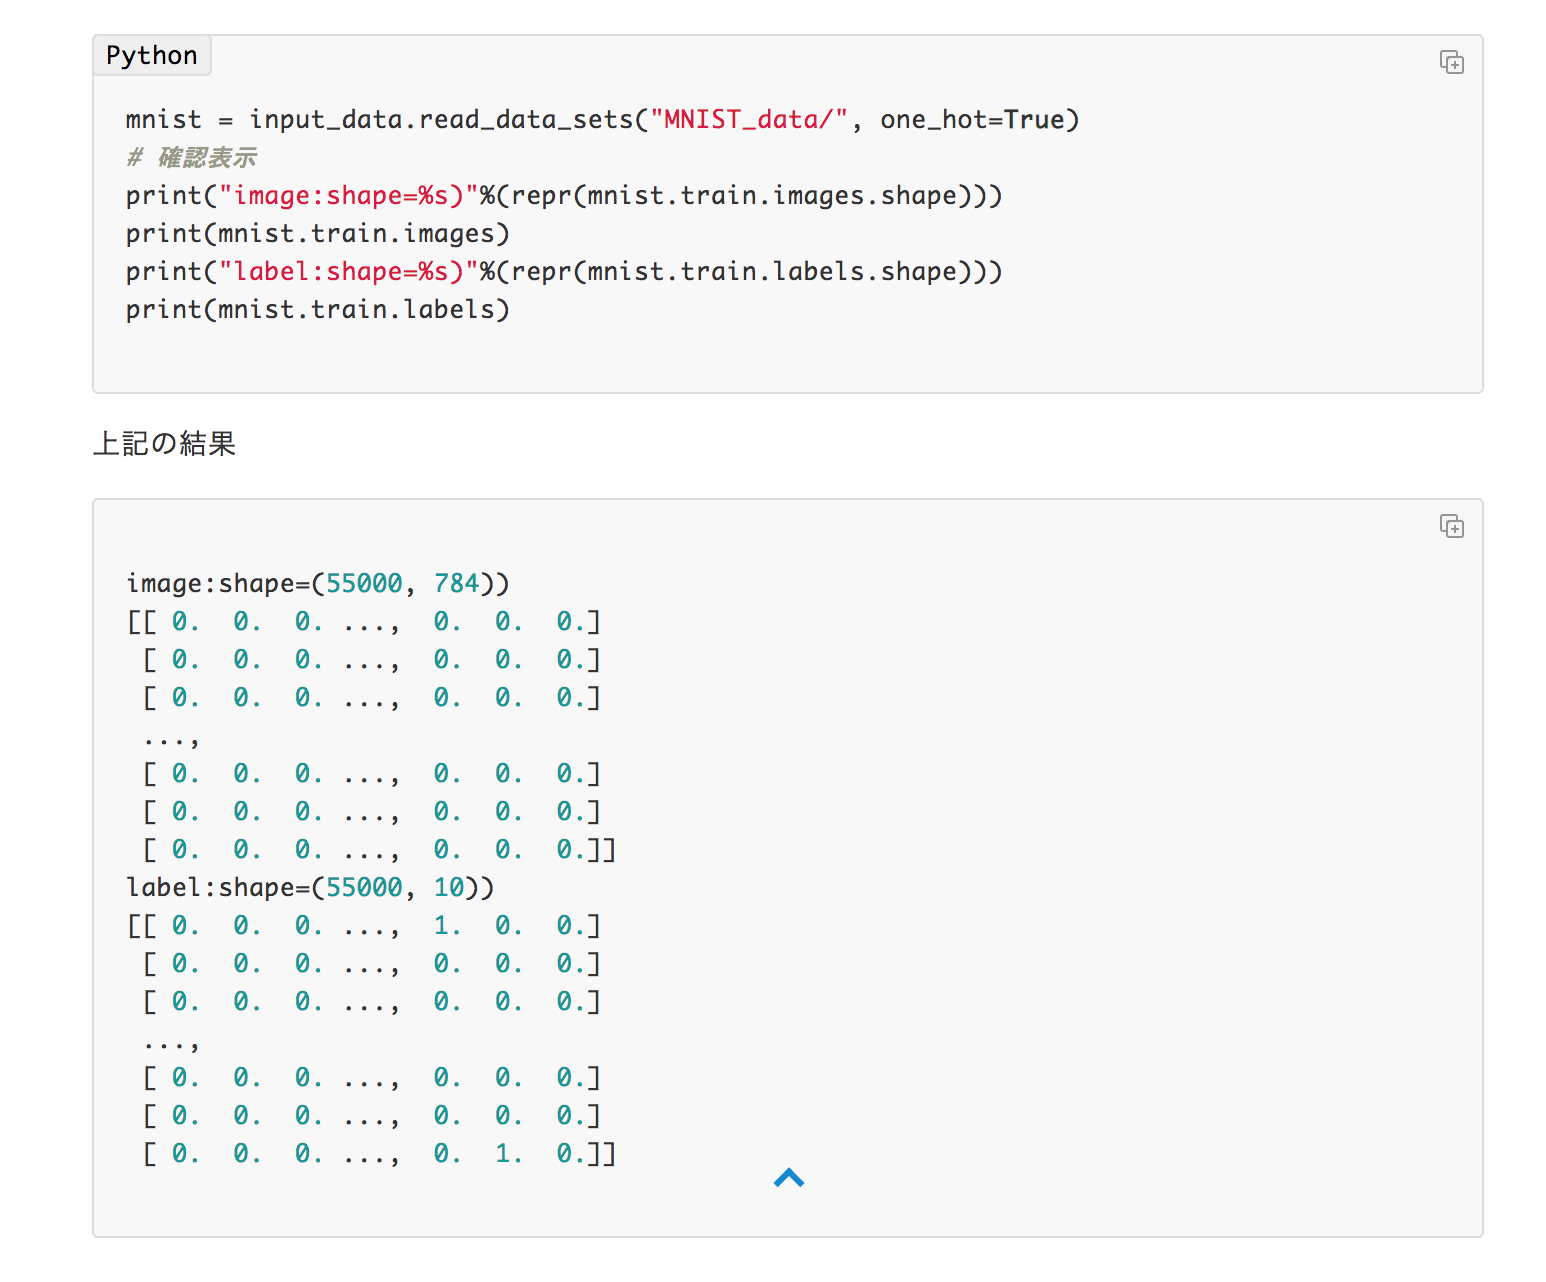
shapeがmnistの対応した次元と一致しない。そのためには、どの次元が合わないかを特定する必要があるが、おそらく合わないのは画像の次元だろうと思われる。=>確認済み。10時限にラベルを展開しても、同様の状況が生まれた。